# This project shows how deep learning can be applied to detect wafer failure

This dataset (WM-811K) wafermap is collected from 47,543 lots in real-world fab. However, not all lots have perfect 25 wafer maps and it may caused by sensor failure or other unknown problems. So we only have 811,457 wafer maps in total

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow
import copy


In [2]:
# import data
data = pd.read_pickle("/content/drive/MyDrive/Python 資料/Residual Network/LSWMD.pkl")


In [3]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


## Clean Data

###  Separate Training and Testing

In [4]:
'''
1. separate training and testing data
2. Because testing data is more than training, we use testing data to train a model and training data for testing purpose.
3. We found that there are totally 638,507 wafers have no labels.
'''
data2 = copy.deepcopy(data)

data_training = data2[data2['trianTestLabel']=='Training']  # num = 54,355
data_training.reset_index(drop=True, inplace=True)

data_testing = data2[data2['trianTestLabel']=='Test']  # num = 118,595
data_testing.reset_index(drop=True, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


- 172,950 wafers have labels
  - 25,519 wafers have real failure patterns
  - 147,431 wafers were still labeled none
- 638,507 wafers have no labels

### Dimension Check

We found that each image has different dimension and this could be a problem for classifcation!
Therefore, we need to transform image size to make the input the same dimension

In [5]:
def find_dim(x):
    return x.shape[0], x.shape[1]
    
data_training['waferMapDim'] = data_training.waferMap.apply(find_dim)
data_training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)"
...,...,...,...,...,...,...,...
54350,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,21.0,[[Training]],[[none]],"(45, 43)"
54351,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,22.0,[[Training]],[[none]],"(45, 43)"
54352,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,23.0,[[Training]],[[none]],"(45, 43)"
54353,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,24.0,[[Training]],[[none]],"(45, 43)"


In [6]:
# difference between largest and smallest image
max(data_training.waferMapDim), min(data_training.waferMapDim)

((212, 84), (15, 3))

In [7]:
# check the most common image dimension (25, 27)
data_training['waferMapDim'].value_counts()

(25, 27)    15684
(27, 25)     9235
(26, 26)     6369
(38, 36)     1877
(33, 37)     1804
            ...  
(67, 65)        1
(63, 63)        1
(52, 53)        1
(56, 63)        1
(53, 44)        1
Name: waferMapDim, Length: 335, dtype: int64

### Imbalance Check

In [8]:
def imbalance_check(data):
    '''
    1. Check number of samples in each failureType.
    '''
    Center=0; Donut=0; Edge_Loc=0; Edge_Ring=0; Loc=0; Random=0; Scratch=0; Near_full=0; none=0
    for i in data['failureType']:
        if i == 'Center':
            Center+=1
        elif i == 'Donut':
            Donut +=1
        elif i == 'Edge-Loc':
            Edge_Loc +=1
        elif i == 'Edge-Ring':
            Edge_Ring+=1
        elif i == 'Loc':
            Loc+=1
        elif i == 'Random':
            Random +=1
        elif i == 'Scratch':
            Scratch += 1
        elif i == 'Near-full':
            Near_full+=1
        elif i == 'none':
            none+=1
    print('Center:', Center, 'Donut:', Donut, 'Edge_Loc:', Edge_Loc, 'Edge_Ring:', Edge_Ring, 'Loc:', Loc, 'Random:', Random, 'Scratch:',Scratch, 'Near_full:', Near_full, 'none:',none)

print("Training data: ")
imbalance_check(data_training)
print("Testing data: ")
imbalance_check(data_testing)

Training data: 
Center: 3462 Donut: 409 Edge_Loc: 2417 Edge_Ring: 8554 Loc: 1620 Random: 609 Scratch: 500 Near_full: 54 none: 36730
Testing data: 
Center: 832 Donut: 146 Edge_Loc: 2772 Edge_Ring: 1126 Loc: 1973 Random: 257 Scratch: 693 Near_full: 95 none: 110701


### Transforming Images
extract image feature with inter_area

In [11]:

class Data_func():
   '''
   This class is basic data functions, used to get exact training data for our model
   '''
   def __init__(self, data):
      self.data = data
      self.X = None
      self.Y = None
      

   def labelEncoding(self,):
      '''
      1. label-encoding failureType
      '''
      self.data['labels'] = self.data['failureType']
      mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
      self.data = self.data.replace({'labels':mapping_type})
      return None

   def extract_feature(self, image):
      '''
      1. extract failure die
      '''
      image[image==0]=1
      return image
   
   def denoise(self, image):
      '''
      1. resize image to 28*28
      2. reduce noise
      '''
      resize_image = cv2.resize(image, (28, 28), interpolation = cv2.INTER_AREA)
      return resize_image

   def get_data(self,):
      '''
      1. resize image all image in training data into same size
      2. one-hot encoding labels
      '''
      X = list()
      for i in self.data['waferMap']:
        
        image = self.extract_feature(i)
        image = self.denoise(image)
        X.append(image)


      self.X = np.array(X).astype(np.float32) / 255.0  # normalize images
      #self.Y = pd.get_dummies(self.data['labels']).astype(np.float32).values # one-hot encoding
      self.Y = self.data['labels'].astype(np.int32).values  # convert to int

   def add_channel(self, x):
      '''
      1. add channel to images
      '''
      return np.expand_dims(x, axis=3)
   
   

tr = copy.deepcopy(data_training)
train = Data_func(tr)
train.labelEncoding()
train.get_data()
train_x, train_y = train.X, train.Y


#data_testing2 = data_testing.sample(frac=0.2,  replace=False, random_state = 1) # sample 10% of data from testing datset
ts = copy.deepcopy(data_testing)
test = Data_func(ts)
test.labelEncoding()
test.get_data()
test_x, test_y = test.X, test.Y
   

In [12]:
np.unique(data_training.waferMap[43], return_counts=True)

(array([1, 2], dtype=uint8), array([2759,  315]))

In [13]:
data_training[data_training['failureType']=='Center']

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
43,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2460.0,lot2,20.0,[[Training]],[[Center]],"(53, 58)"
47,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2460.0,lot2,25.0,[[Training]],[[Center]],"(53, 58)"
543,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,...",533.0,lot25,5.0,[[Training]],[[Center]],"(26, 26)"
645,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,...",533.0,lot30,5.0,[[Training]],[[Center]],"(26, 26)"
783,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,...",533.0,lot36,19.0,[[Training]],[[Center]],"(26, 26)"
...,...,...,...,...,...,...,...
47506,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2,...",505.0,lot45101,2.0,[[Training]],[[Center]],"(27, 25)"
50018,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,...",507.0,lot45204,25.0,[[Training]],[[Center]],"(27, 25)"
51757,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,...",953.0,lot46453,21.0,[[Training]],[[Center]],"(33, 37)"
51778,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",952.0,lot46454,17.0,[[Training]],[[Center]],"(33, 37)"


### Visualization

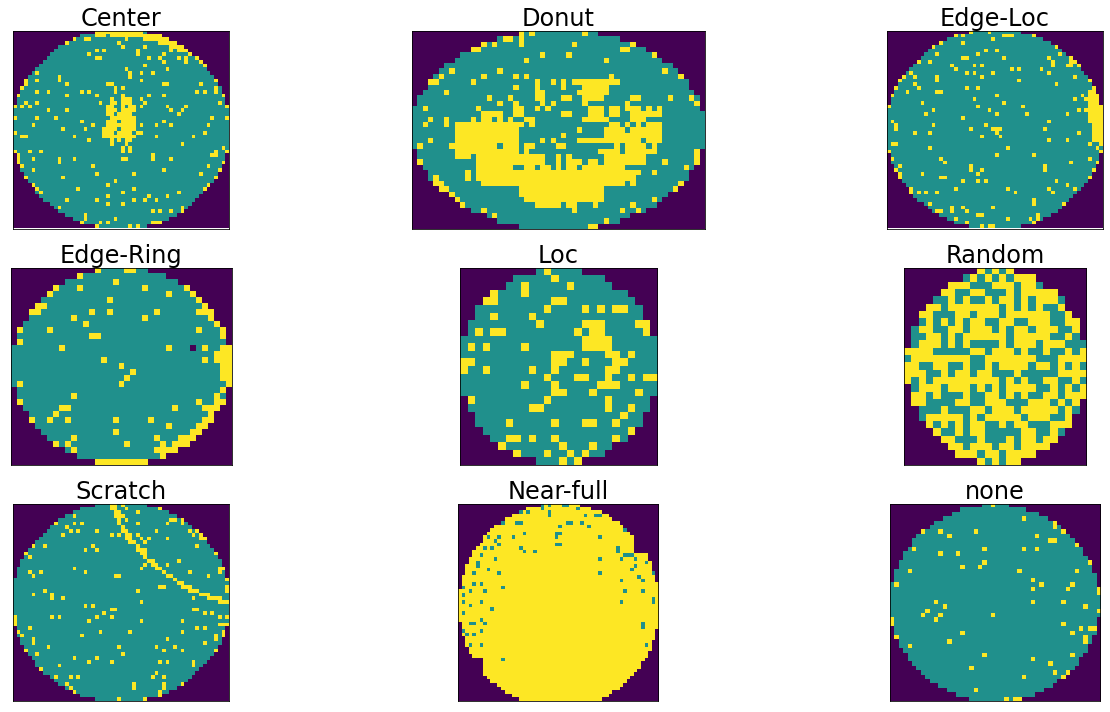

In [9]:
'''
Failure Pattern Visualizaiton
'''

# Before image transformation
x = [43, 6509, 35, 53163, 578, 43894, 130,  25082, 4]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full', 'None']


fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(9):
    img = data_training.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(data_training.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

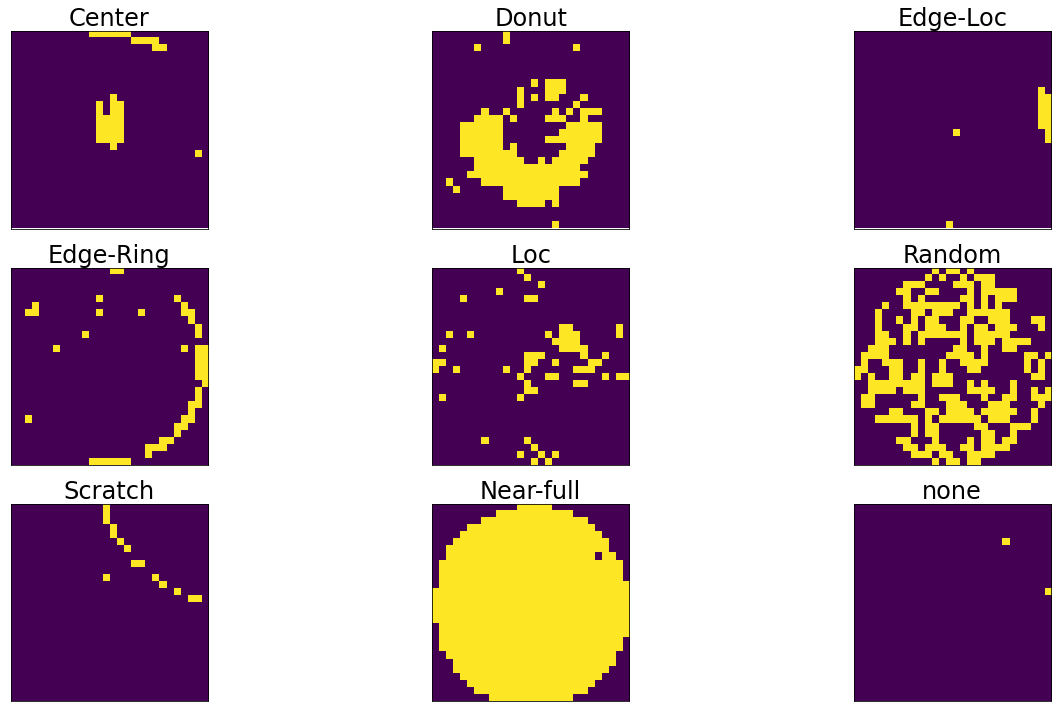

In [17]:

# After image transformation
x = [43, 6509, 35, 53163, 578, 43894, 130,  25082, 4]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full', 'None']


fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(9):
    img = train_x[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(data_training.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

## CNN

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Hyper-parameters
epoch = 200
batch_size = 500
learning_rate = 0.01
num_class = 9

# Set up gpu device
cuda = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Put training data into DataLoader
train_data = torch.utils.data.TensorDataset(torch.unsqueeze(torch.from_numpy(train_x), dim=1), torch.from_numpy(train_y))
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=False)

# Put testing data into DataLoader
test_data = torch.utils.data.TensorDataset(torch.unsqueeze(torch.from_numpy(test_x), dim=1), torch.from_numpy(test_y))
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False)

# Add channel to testing data
test_x_torch = torch.autograd.Variable(torch.unsqueeze(torch.from_numpy(test_x), dim=1))
test_y_torch = torch.autograd.Variable(torch.from_numpy(test_y))

In [ ]:
class CNN(nn.Module):
    '''
    define CNN structure
    '''
    def __init__(self, num_class):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.MaxPool2d(kernel_size=2),
               
        )

        self.conv2 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=30, kernel_size=5, stride=1, padding=2),
              nn.ReLU(),
              nn.BatchNorm2d(30),
              nn.MaxPool2d(kernel_size=2), 
        )

        self.conv3 = nn.Sequential(
              nn.Conv2d(in_channels=30, out_channels=20, kernel_size=5, stride=1, padding=2),
              nn.ReLU(),
              nn.BatchNorm2d(20),
              nn.MaxPool2d(kernel_size=2),
               
        )

        self.conv4 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=10, kernel_size=5, stride=1, padding=2),
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.MaxPool2d(kernel_size=2),
               
        )

        self.dense1 = nn.Linear(in_features=10*1*1, out_features=10)
        self.dense1_dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(in_features=10, out_features=10)
        self.dense2_dropout = nn.Dropout(0.5)
        self.output = nn.Linear(in_features=10, out_features=num_class)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        

        x = x.view(x.size(0), -1) # flatten
        
        x = nn.functional.relu(self.dense1(x))
        x = nn.functional.relu(self.dense1(x))
        pre = nn.functional.log_softmax(self.output(x), -1)
        return pre



In [ ]:
cnn = CNN(num_class)
cnn.to(cuda)
print(cnn) # show structure of the model
# choose optimizer and loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr= learning_rate)
loss_func = nn.CrossEntropyLoss().to(cuda)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): 

In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (x, y) in enumerate(data_loader):            
        x = x.to(cuda)
        y = y.to(cuda)
        prediction = model(x)
        _, predicted_labels = torch.max(prediction, 1)
        num_examples += y.size(0)
        correct_pred += (predicted_labels.to(cuda) == y.to(cuda)).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
'''
train first cnn
'''
for e in range(epoch): # for each epoch
    cnn = cnn.train()
    for step, (x, y) in enumerate(train_loader): # for each mini-batch
        '''
        b_x = torch.autograd.Variable(x).to(cuda)
        b_y = torch.autograd.Variable(y).to(cuda)
        '''
        b_x = x.to(cuda)
        b_y = y.to(cuda)
        
        prediction = cnn(b_x)
        loss = loss_func(prediction.to(cuda), b_y.type(torch.LongTensor).to(cuda))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print('Epoch: %03d/%03d | Batch: %03d/%03d | Loss: %.4f' %(e+1, epoch, step, len(train_loader), loss))
           
    torch.no_grad()
    print('Epoch: %03d/%03d | training accuracy: %.2f%%' %(e+1, epoch, compute_accuracy(cnn, train_loader)))


Epoch: 001/200 | Batch: 000/109 | Loss: 2.1098
Epoch: 001/200 | Batch: 100/109 | Loss: 0.0546
Epoch: 001/200 | training accuracy: 67.57%
Epoch: 002/200 | Batch: 000/109 | Loss: 0.4162
Epoch: 002/200 | Batch: 100/109 | Loss: 0.0740
Epoch: 002/200 | training accuracy: 67.57%
Epoch: 003/200 | Batch: 000/109 | Loss: 0.3299
Epoch: 003/200 | Batch: 100/109 | Loss: 0.7065
Epoch: 003/200 | training accuracy: 67.52%
Epoch: 004/200 | Batch: 000/109 | Loss: 0.4562
Epoch: 004/200 | Batch: 100/109 | Loss: 0.1436
Epoch: 004/200 | training accuracy: 67.57%
Epoch: 005/200 | Batch: 000/109 | Loss: 0.3381
Epoch: 005/200 | Batch: 100/109 | Loss: 0.4458
Epoch: 005/200 | training accuracy: 67.57%
Epoch: 006/200 | Batch: 000/109 | Loss: 0.4840
Epoch: 006/200 | Batch: 100/109 | Loss: 0.0468
Epoch: 006/200 | training accuracy: 67.57%
Epoch: 007/200 | Batch: 000/109 | Loss: 0.2933
Epoch: 007/200 | Batch: 100/109 | Loss: 0.5402
Epoch: 007/200 | training accuracy: 67.57%
Epoch: 008/200 | Batch: 000/109 | Loss: 0

In [ ]:
print('Test accuracy: %.2f%%' % (compute_accuracy(cnn, test_loader)))

Test accuracy: 95.44%
